In [1]:
import sys
sys.path.insert(1, '/home/ias627/tools')

In [2]:
from abg_python.snapshot_utils import openSnapshot
from abg_python.cosmo_utils import load_AHF
import numpy as np
import matplotlib.pyplot as plt

In [3]:
officialSimNames = {'h206':'A1',
                    'h29':'A2',
                    'h113':'A4',
                    'h2':'A8'}
simNameBase = '_HR_sn1dy300ro100ss'

In [4]:
def inrange(a, ra):
    a1, a2 = ra
    return (a1 <= a)&(a <= a2)

In [5]:
def load_p0(simName, snapnum):
    p0 = openSnapshot(f'/projects/b1026/anglesd/FIRE/{simName}', snapnum, 0, loud=1)
    
    print(f"Loading redshift {p0['Redshift']}")

    posC, Rvir = load_AHF('', snapnum, p0['Redshift'], hubble=p0['HubbleParam'], ahf_path=f'/projects/b1026/halo_files/anglesd_m13/{simName}', extra_names_to_read=[])

    # position relative to center
    p0['CoordinatesRelative'] = p0['Coordinates'] - posC

    # distance from halo center
    p0['r'] = np.linalg.norm(p0['CoordinatesRelative'], axis=1)

    # distance from halo center in units of virial radius
    p0['r_scaled'] = p0['r']/Rvir

    # volume of each particle
    p0['Vi'] = p0['Masses']/p0['Density']
    
    p0['posC'] = posC
    p0['Rvir'] = Rvir
    
    return p0

In [22]:
def logTavgGen( p0, Tmask=True, rbins=np.power(10, np.arange(np.log10(0.005258639741921723), np.log10(1.9597976388995666), 0.05)) ):
    '''
    Default Tmask and rbins chosen to match Stern+20 Fig. 6.
    '''
#     Tmask = p0['Temperature'] >= 1e5
    rmid = (rbins[:-1]+rbins[1:])/2
    logTavgbins = []

    for r0,r1 in zip(rbins[:-1],rbins[1:]):
        idx = np.flatnonzero(Tmask & inrange( p0['r_scaled'], (r0, r1) ))
        Vbin = 4/3 * np.pi * ((r1-r0)*p0['Rvir'])**3 #TODO: incorrect volume of shell
        logTavg = np.sum(p0['Masses'][idx]) / np.sum(p0['Vi'][idx]) #Vbin
        logTavgbins.append(logTavg)
    return rmid, logTavgbins

In [7]:
def load_p0_allsims(snapnum):
    p0_allsims = {}
    for simTag in officialSimNames.keys():
        simName = simTag + simNameBase
        p0 = load_p0(simName, snapnum)
        p0_allsims[simName] = p0
    return p0_allsims

In [8]:
def data_allsims_gen(p0_allsims):
    data_allsims = {}
    for simTag in officialSimNames.keys():
        simName = simTag + simNameBase
        p0 = p0_allsims[simName]
        rmid, logTavgbins = logTavgGen(p0)
        data_allsims[simTag]= (p0, rmid, logTavgbins)
    return data_allsims

In [18]:
def plot_allsims(data_allsims, z_round2):
    plt.figure(dpi=200)

    for simTag, (p0, rmid, logTavgbins) in data_allsims.items():
        plt.plot(np.log10(rmid), np.log10(logTavgbins), '.', label=f'{simTag}_{officialSimNames[simTag]}{simNameBase}')
        assert np.round(p0["Redshift"], 2) == z_round2

    plt.xlabel(r'$\log (r/R_{vir})$')
#     plt.ylabel(r'$\left<\log \left(T/\mathrm{K}\right)\right>$')
    plt.legend()
    plt.title(f'$z={np.round(p0["Redshift"],2)}$')
    
    # chosen for z=1.0 and z=1.1 for both plot_allsims and Stern_comparison
#     plt.xlim(-2.4076934712894045, 0.4207781206510557)
#     plt.ylim(5.256989216804504, 7.472256517410278)
    plt.ylim(-8, -2)

In [10]:
%time p0_allsims_277 = load_p0_allsims(277)
%time p0_allsims_262 = load_p0_allsims(262)

/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.0.hdf5
This is a cosmological snapshot... converting to physical units
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.1.hdf5
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.2.hdf5
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.3.hdf5
Loading redshift 1.0000000007662364
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.0.hdf5
This is a cosmological snapshot... converting to physical units
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.1.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.2.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.3.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277.4.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_277/snapshot_277

In [9]:
#Tmask = True#p0['Temperature'] >= 1e5

# z=1

## No-feedback runs

In [23]:
data_allsims_277 = data_allsims_gen(p0_allsims_277)

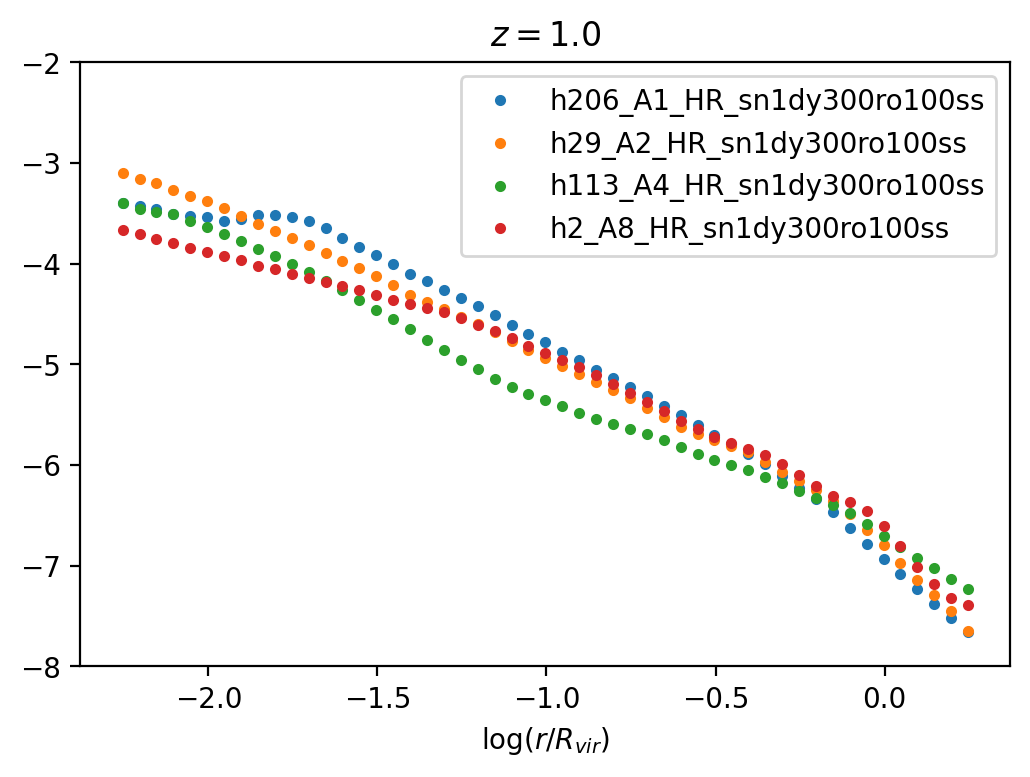

In [21]:
# Vbin is total volume of particles
# T >= 1e5
plot_allsims(data_allsims_277, 1.00)

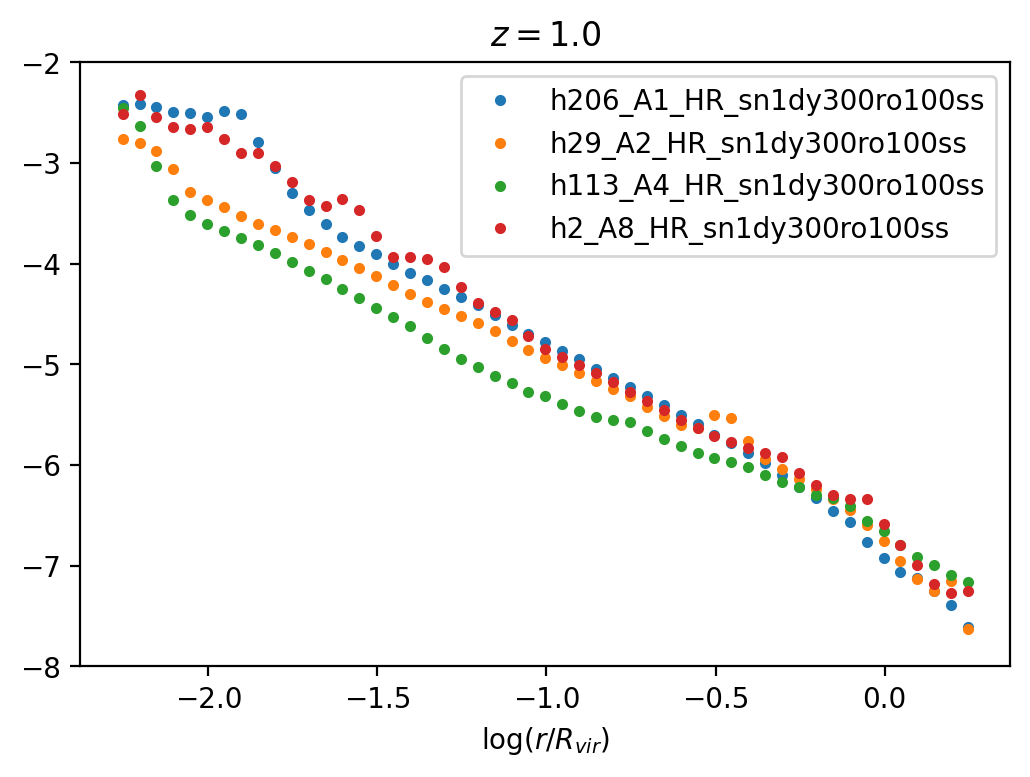

In [24]:
# Vbin is total volume of particles
plot_allsims(data_allsims_277, 1.00)

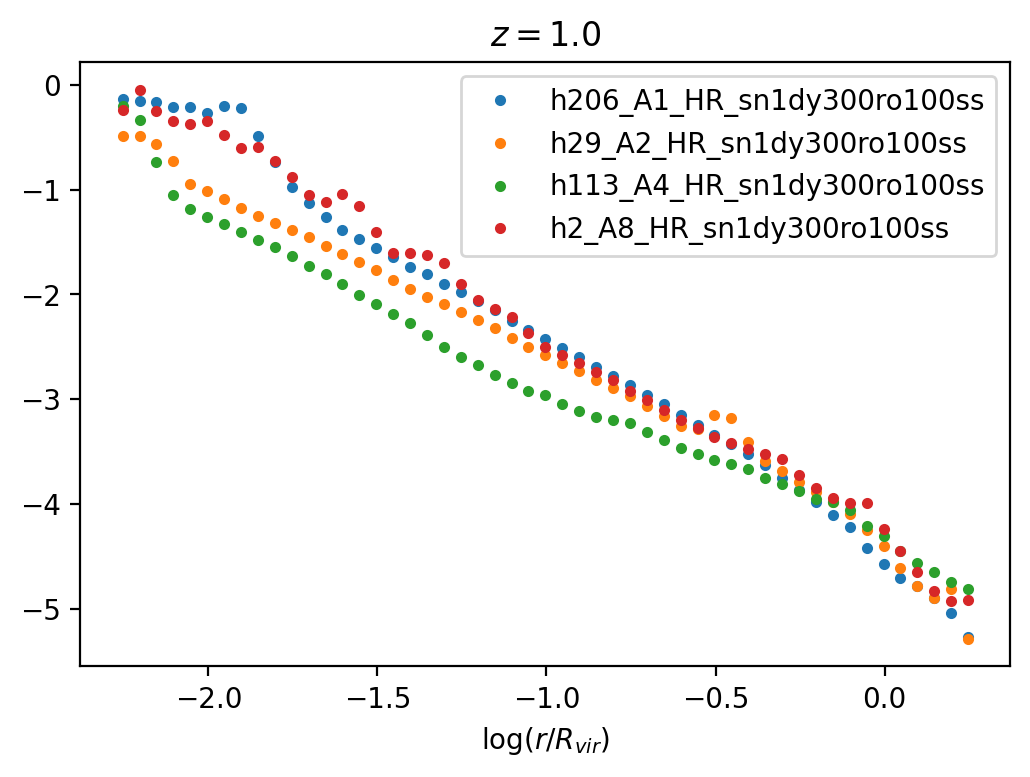

In [38]:
# Vbin in code units
plot_allsims(data_allsims_277, 1.00)

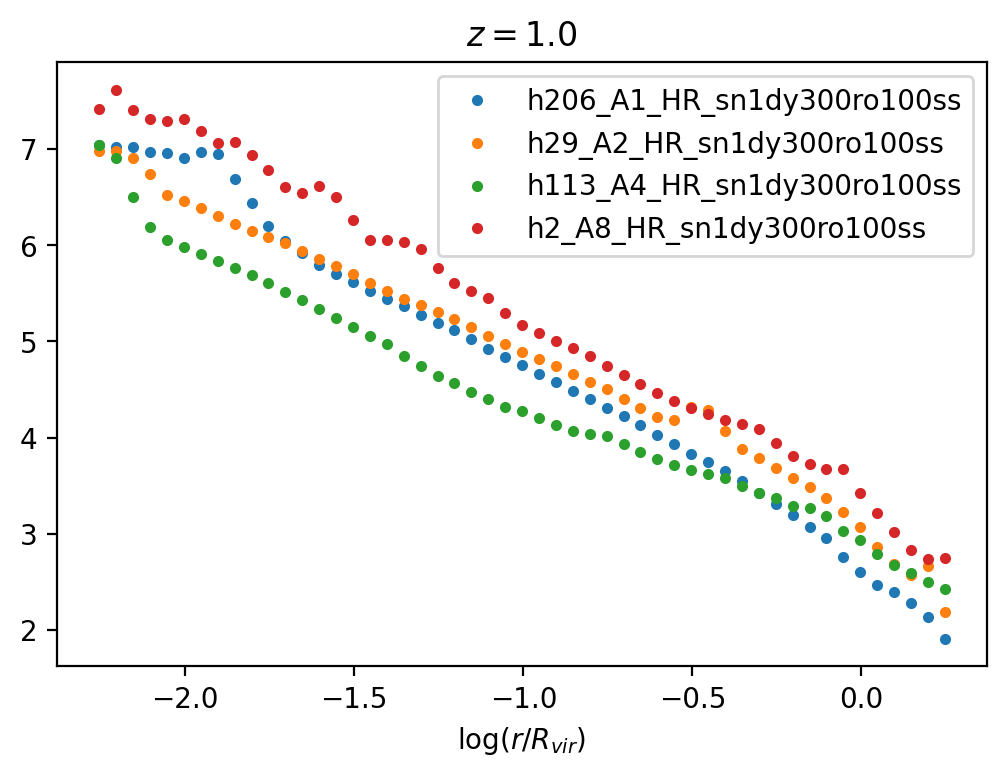

In [18]:
# orig (Vbin in units of Rvir^3)
plot_allsims(data_allsims_277, 1.00)
# plt.savefig('Figures/Tprofile_allsims_z1.png')

# z=1.1

## No-feedback runs

In [21]:
data_allsims_262 = data_allsims_gen(262)

/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.0.hdf5
This is a cosmological snapshot... converting to physical units
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.1.hdf5
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.2.hdf5
/projects/b1026/anglesd/FIRE/h206_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.3.hdf5
Loading redshift 1.0999998958284714
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.0.hdf5
This is a cosmological snapshot... converting to physical units
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.1.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.2.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.3.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_262/snapshot_262.4.hdf5
/projects/b1026/anglesd/FIRE/h29_HR_sn1dy300ro100ss/snapdir_262/snapshot_262

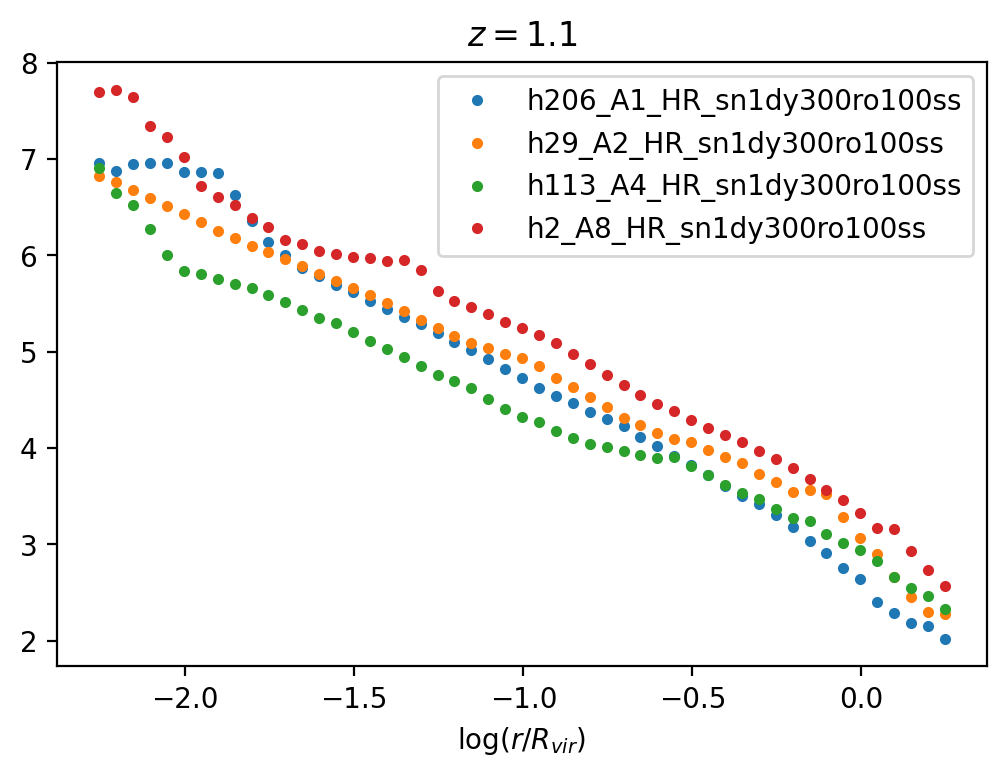

In [22]:
plot_allsims(data_allsims_262, 1.10)
# plt.savefig('Figures/Tprofile_allsims_z1_1.png')